# Not meant to be run in Colab

## There are also quite a bit of weird print statements (Taking them back out will take a bit of time which i didnt want to use) throughout which i used to figure out what different variables and arrays were and how to use them properly

In [ ]:
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import cv2 as cv
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow._api.v2.compat.v1 as tf2
from keras.layers import LeakyReLU

# config = tf2.ConfigProto()
# config.gpu_options.allow_growth = True
# session = tf2.InteractiveSession(config=config)
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.set_logical_device_configuration(
    physical_devices[0],
    tf.config.LogicalDeviceConfiguration(memory_limit=4096))

  logical_devices = tf.config.list_logical_devices('GPU')
  assert len(logical_devices) == len(physical_devices) + 1

  tf.config.set_logical_device_configuration(
    physical_devices[0],
    tf.config.LogicalDeviceConfiguration(memory_limit=4096))
except:
#   # Invalid device or cannot modify logical devices once initialized.
  pass


training_dir = 'D:\Coding\ML\convolution_nn\content/training'
image_size = (100, 100)

# Split up the training data images into training and validations sets
# We'll use and ImageDataGenerator to do the splits
# ImageDataGenerator can also be used to do preprocessing and agumentation on the files as can be seen with rescale

train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2,
        zoom_range=.1
        )
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
        )

train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size = image_size,
        subset="training",
        batch_size=32,
        class_mode='sparse',
        seed=42,shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
        training_dir,
        target_size=image_size,
        batch_size=32,
        class_mode='sparse',
        subset="validation",
        seed=42)

test_dir = 'D:\Coding\ML\convolution_nn\content'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        classes=['test'],
        class_mode='sparse',
        shuffle=False)


# fig = plt.figure(figsize=(20, 20))
  
# # setting values to rows and column variables
# rows = 7
# columns = 7
  
# # reading images
# d = {}
# for x in range(0, 43):
#     fig.add_subplot(rows, columns, x+1)
#     x = str(x)
#     x = str(x.zfill(2))
#     images = f"D:\Coding\ML\convolution_nn\content/training/000{x}/00000_00000.jpg"
#     img = cv.imread(images)
#     plt.imshow(img)
#     plt.axis('off')
#     plt.title(f"{x}")

# plt.show()



model = tf.keras.models.Sequential([
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation=LeakyReLU(alpha=0.05), input_shape=(100,100,3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation=LeakyReLU(alpha=0.05)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation=LeakyReLU(alpha=0.05)),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation=LeakyReLU(alpha=0.05)),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dropout(0.3),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation=LeakyReLU(alpha=0.05)),
    tf.keras.layers.Dense(43, activation='softmax')
])

tf.keras.optimizers.Adam(
    learning_rate= 0.002,
    beta_1=0.9,
    beta_2=0.999,
    # epsilon=1e-08,
    amsgrad=False,
    name="adam"
)
model.summary()

model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])

history = model.fit(train_generator, epochs = 60, batch_size = 32,steps_per_epoch=500, validation_data = validation_generator, verbose = 1)

# import coremltools as ct
# mlmodel = ct.convert(model)
# mlmodel.save("roadsigns.mlmodel")
# model.save("rps.h5")
import coremltools as ct
import keras
# coreml_model = coremltools.converters.keras.convert(model)
# coreml_model.save('D:\Coding\ML/Signs_model.mlmodel')
model.save('signs_keras_model.h5')


plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

base = pd.read_csv("D:\Coding\ML\convolution_nn\content/test_classes.csv")
base = base.ClassId
from sklearn.metrics import accuracy_score



pred = model.predict(test_generator, verbose=1)
print(pred)
print(len(pred))
cl = []
for i in range(0, len(pred)):
    cl.append(np.argmax(pred[i]))
cl = np.array(cl)
# print("Pred:")
# print(pred)
# print(type(pred))
# print(len(pred))

# print("Pred[1]:")
# print(pred[1])
# print(type(pred[1]))
# print(len(pred[1]))

# print("Pred[:,0]:")
# print(pred[:,0])
# print(type(pred[:,0]))
# print(len(pred[:,0]))

# print("cl:")
# print(cl)
# print(type(cl))
# print(len(cl))

filenames=test_generator.filenames
results=pd.DataFrame({"file":filenames,"pr":pred[:,0], "classy":cl})

# pred = results.pr
# classy = results.classy
# print(classy.head())
# print(pred.head)
Accuracy = accuracy_score(base, cl)
print("accuracy on Test:", Accuracy)



from sklearn import metrics
from sklearn.metrics import multilabel_confusion_matrix
print("Accuracy:",metrics.accuracy_score(base, cl))
print("Recall: ", metrics.recall_score(base, cl, average='micro'))
# print(f"This is base \n Base: {base}")
# print(f"This is Classy \n Classy: {classy}")
def plot_image(i, predictions_array, true_label, img):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks()
  plt.yticks()
  plt.imshow(img)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  predicted_label = str(predicted_label)
  predicted_label = predicted_label.zfill(2)
  predicted_label = (f"000{predicted_label}")
  true_label = str(true_label)
  true_label = true_label.zfill(2)
  true_label = (f"000{true_label}")

  plt.xlabel("{} {:2.0f}% ({})".format(train_generator.class_indices[predicted_label],
                                100*np.max(predictions_array),
                                train_generator.class_indices[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(43))
  plt.yticks()
  print(predictions_array)
  thisplot = plt.bar(range(43), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

def gen_file(n):
    for i in test_generator:
        idx = int((test_generator.batch_index - 1) * test_generator.batch_size)
        fileimg = (test_generator.filenames[idx : idx + test_generator.batch_size])
        fileimg = np.array(fileimg)
        fileimg = fileimg[n]
        print(os.getcwd())
        return plt.imread(f"D:\Coding\ML\convolution_nn\content/{fileimg}")
i = 0
print(pred[i])
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plot_image(i, pred[i], base, gen_file(i))
plt.subplot(1,2,2)
plot_value_array(i, pred[i],  base)
plt.show()

i = 12
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plot_image(i, pred[i], base, gen_file(i))
plt.subplot(1,2,2)
plot_value_array(i, pred[i],  base)
plt.show()

num_rows = 5
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, pred[i], base, gen_file(i))
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, pred[i], base)
plt.tight_layout()
plt.show()

img = plt.imread("D:\Coding\ML\convolution_nn\content/test/00000.jpg")

img = (np.expand_dims(img,0))


predictions_single = model.predict(img)

print(predictions_single)

plot_value_array(1, predictions_single[0], base)
_ = plt.xticks(range(43), train_generator.class_indices, rotation=45)

np.argmax(predictions_single[0])

## Tests

In [ ]:
from keras_preprocessing.image import ImageDataGenerator
import shap
from shap import DeepExplainer
import tensorflow as tf
model = tf.keras.models.load_model('D:\Coding\signs_keras_model.h5')
training_dir = 'D:\Coding\ML\convolution_nn\content/training'
image_size = (100, 100)


# Split up the training data images into training and validations sets
# We'll use and ImageDataGenerator to do the splits
# ImageDataGenerator can also be used to do preprocessing and agumentation on the files as can be seen with rescale

train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2,
        zoom_range=.1
        )
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
        )

train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size = image_size,
        subset="training",
        batch_size=32,
        class_mode='sparse',
        seed=42,shuffle=True)

background1, lbls1 = next(train_generator)
lbls1 = lbls1.reshape(lbls1.shape[0], 1)
print(lbls1)
e = DeepExplainer((model), background1).shap_values(background1)

In [ ]:
from tensorflow import keras

In [ ]:
!pip install coremltools

     |████████████████████████████████| 1.6 MB 5.0 MB/s 


In [ ]:
model = keras.models.load_model('/content/signs_keras_model.h5')

In [ ]:
import coremltools as ct
mlmodel = ct.convert(model)
mlmodel.save('/content/model.mlmodel')


Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 80/80 [00:00<00:00, 370.51 ops/s]


In [ ]:
import shap

In [ ]:
# !unzip training.zip

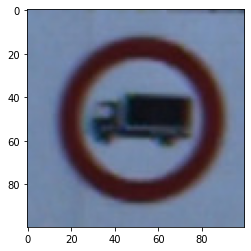

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
img = plt.imread("/content/test/00000.jpg")
plt.imshow(img);
img2 = (np.expand_dims(img,0))

In [ ]:
img = img2.reshape(img2.shape[0], 100, 100, -1)

In [ ]:
img2.shape[0]

1

In [ ]:
img.size

30000

In [ ]:
import tensorflow as tf

In [ ]:
training_dir = '/content/training'
train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2,
        zoom_range=.1
        )
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
        )

train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size = image_size,
        subset="training",
        batch_size=32,
        class_mode='sparse',
        seed=42,shuffle=True)

Found 31368 images belonging to 43 classes.


In [ ]:
from keras_preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)
image_size = (100, 100)
test_dir = '/content'
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=6,
        classes=['test'],
        class_mode='sparse',
        shuffle=False)

Found 6 images belonging to 1 classes.


In [ ]:
print(test_generator.filenames)

['test/00000.jpg', 'test/00001.jpg', 'test/00002.jpg', 'test/00067.jpg', 'test/00092.jpg', 'test/00096.jpg']


In [ ]:
import os
import pandas as pd
file_name = sorted(os.listdir('test'))
eval_df = pd.DataFrame()

eval_df['image_name'] = file_name
print(eval_df.head(6))
eval_df['target'] = [16,1,38,2,2,3]

  image_name
0  00000.jpg
1  00001.jpg
2  00002.jpg
3  00067.jpg
4  00092.jpg
5  00096.jpg


In [ ]:
pred = model.predict(test_generator)
cl = []
for i in range(0, len(pred)):
    cl.append(np.argmax(pred[i]))
cl = np.array(cl)
eval_df['preds'] = cl
display(eval_df.head(6))

,image_name,target,preds
0,00000.jpg,16,16
1,00001.jpg,1,1
2,00002.jpg,38,38
3,00067.jpg,2,2
4,00092.jpg,2,2
5,00096.jpg,3,3


In [ ]:
background1, lbls1 = next(test_generator)
lbls1 = lbls1.reshape(lbls1.shape[0], 1)

In [ ]:
background, lbls = next(test_generator)
lbls = lbls.reshape(lbls.shape[0], 1)

In [ ]:
print(test_generator)

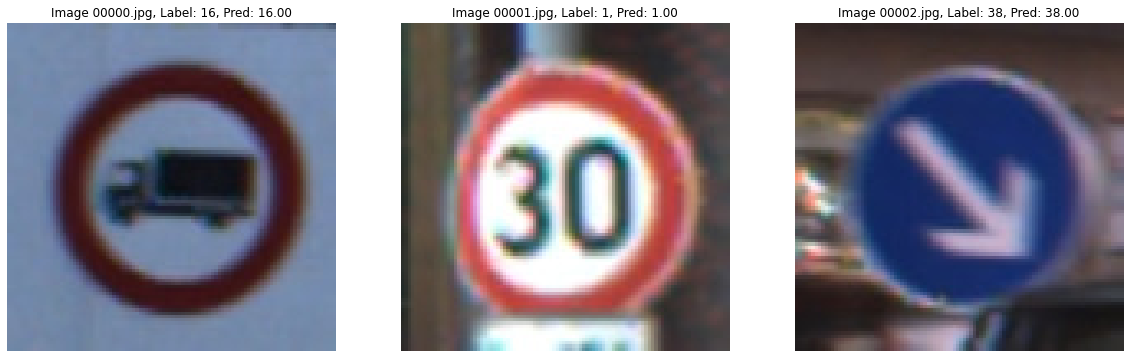

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 14))
axes = axes.flatten()
x = 0
axes[x].imshow(background[x])
axes[x+1].imshow(background[x+1])
axes[x+2].imshow(background[x+2])

axes[x].set_title(f"Image {eval_df['image_name'].values[x]}, Label: {eval_df['target'].values[x]}, Pred: {eval_df['preds'].values[x]:.2f}")
axes[x+1].set_title(f"Image {eval_df['image_name'].values[x+1]}, Label: {eval_df['target'].values[x+1]}, Pred: {eval_df['preds'].values[x+1]:.2f}")
axes[x+2].set_title(f"Image {eval_df['image_name'].values[x+2]}, Label: {eval_df['target'].values[x+2]}, Pred: {eval_df['preds'].values[x+2]:.2f}")

axes[x].set_axis_off()
axes[x+1].set_axis_off()
axes[x+2].set_axis_off()
    
plt.show()

In [ ]:
e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(background)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


StagingError: ignored

In [ ]:
e = shap.GradientExplainer(model, background)
shap_values = e.shap_values(background) 

# plot the feature attributions

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


StagingError: ignored

In [ ]:
def image_plot(shap_values, pixel_values, labels=None, preds=None, names=None, width=20, aspect=0.2, hspace=0.2, labelpad=None, show=True, fig_size=None):
    """ Plots SHAP values for image inputs.
    Parameters
    ----------
    shap_values : [numpy.array]
        List of arrays of SHAP values. Each array has the shap (# samples x width x height x channels), and the
        length of the list is equal to the number of model outputs that are being explained.
    pixel_values : numpy.array
        Matrix of pixel values (# samples x width x height x channels) for each image. It should be the same
        shape as each array in the shap_values list of arrays.
    labels : list
        List of names for each of the model outputs that are being explained. This list should be the same length
        as the shap_values list.
    width : float
        The width of the produced matplotlib plot.
    labelpad : float
        How much padding to use around the model output labels.
    show : bool
        Whether matplotlib.pyplot.show() is called before returning. Setting this to False allows the plot
        to be customized further after it has been created.
    """

    multi_output = True
    if type(shap_values) != list:
        multi_output = False
        shap_values = [shap_values]

    # make sure labels
    if labels is not None:
        assert labels.shape[0] == shap_values[0].shape[0], "Labels must have same row count as shap_values arrays!"
        if multi_output:
            assert labels.shape[1] == len(shap_values), "Labels must have a column for each output in shap_values!"
        else:
            assert len(labels.shape) == 1, "Labels must be a vector for single output shap_values."

    label_kwargs = {} if labelpad is None else {'pad': labelpad}

    # plot our explanations
    x = pixel_values
    if fig_size is None:
        fig_size = np.array([3 * (len(shap_values) + 1), 2.5 * (x.shape[0] + 1)])
        if fig_size[0] > width:
            fig_size *= width / fig_size[0]
    fig, axes = plt.subplots(nrows=x.shape[0], ncols=len(shap_values) + 1, figsize=fig_size)
    if len(axes.shape) == 1:
        axes = axes.reshape(1,axes.size)
    for row in range(x.shape[0]):
        x_curr = x[row].copy()

        # make sure
        if len(x_curr.shape) == 3 and x_curr.shape[2] == 1:
            x_curr = x_curr.reshape(x_curr.shape[:2])
        if x_curr.max() > 1:
            x_curr /= 255.

        # get a grayscale version of the image
        if len(x_curr.shape) == 3 and x_curr.shape[2] == 3:
            x_curr_gray = (0.2989 * x_curr[:,:,0] + 0.5870 * x_curr[:,:,1] + 0.1140 * x_curr[:,:,2]) # rgb to gray
        else:
            x_curr_gray = x_curr

        axes[row,0].imshow(x_curr, cmap=plt.get_cmap('gray'))
        axes[row,0].set_title(f'Image: {names[row]}', **label_kwargs)
        axes[row,0].axis('off')
        if len(shap_values[0][row].shape) == 2:
            abs_vals = np.stack([np.abs(shap_values[i]) for i in range(len(shap_values))], 0).flatten()
        else:
            abs_vals = np.stack([np.abs(shap_values[i].sum(-1)) for i in range(len(shap_values))], 0).flatten()
        max_val = np.nanpercentile(abs_vals, 99.9)
        for i in range(len(shap_values)):
            if labels is not None:
                axes[row,i+1].set_title(f'Label: {labels[row,i]} Pred: {preds[row,i]:.2f}', **label_kwargs)
            sv = shap_values[i][row] if len(shap_values[i][row].shape) == 2 else shap_values[i][row].sum(-1)
            axes[row,i+1].imshow(x_curr_gray, cmap=plt.get_cmap('gray'), alpha=0.15, extent=(-1, sv.shape[1], sv.shape[0], -1))
            im = axes[row,i+1].imshow(sv, cmap=shap.plots.colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
            axes[row,i+1].axis('off')
    if hspace == 'auto':
        fig.tight_layout()
    else:
        fig.subplots_adjust(hspace=hspace)
    cb = fig.colorbar(im, ax=np.ravel(axes).tolist(), label="SHAP value", orientation="horizontal", aspect=fig_size[0]/aspect)
    cb.outline.set_visible(False)
    if show:
        plt.show()

In [ ]:
shap_values_positive = shap.GradientExplainer(model, background1).shap_values(background1)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


StagingError: ignored

In [ ]:
shap_values_positive = shap.DeepExplainer(model, background).shap_values(background)

# plot the feature attributions


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


StagingError: ignored

In [ ]:
shap_values = shap_values_positive.shap_values(x_test[1:5])

AttributeError: ignored

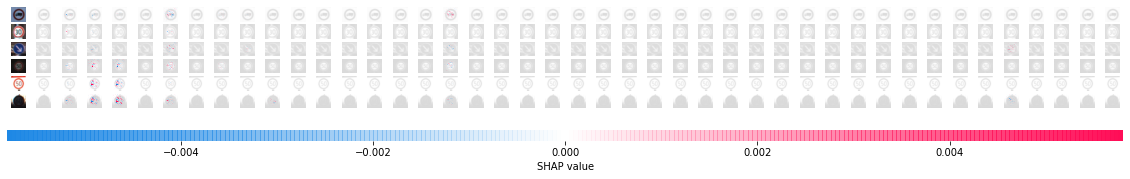

In [ ]:
shap.image_plot(shap_values, background)

In [ ]:
eval_df.head(6)

,image_name,target,preds
0,00000.jpg,16,16
1,00001.jpg,1,1
2,00002.jpg,38,38
3,00067.jpg,2,2
4,00092.jpg,2,2
5,00096.jpg,3,3


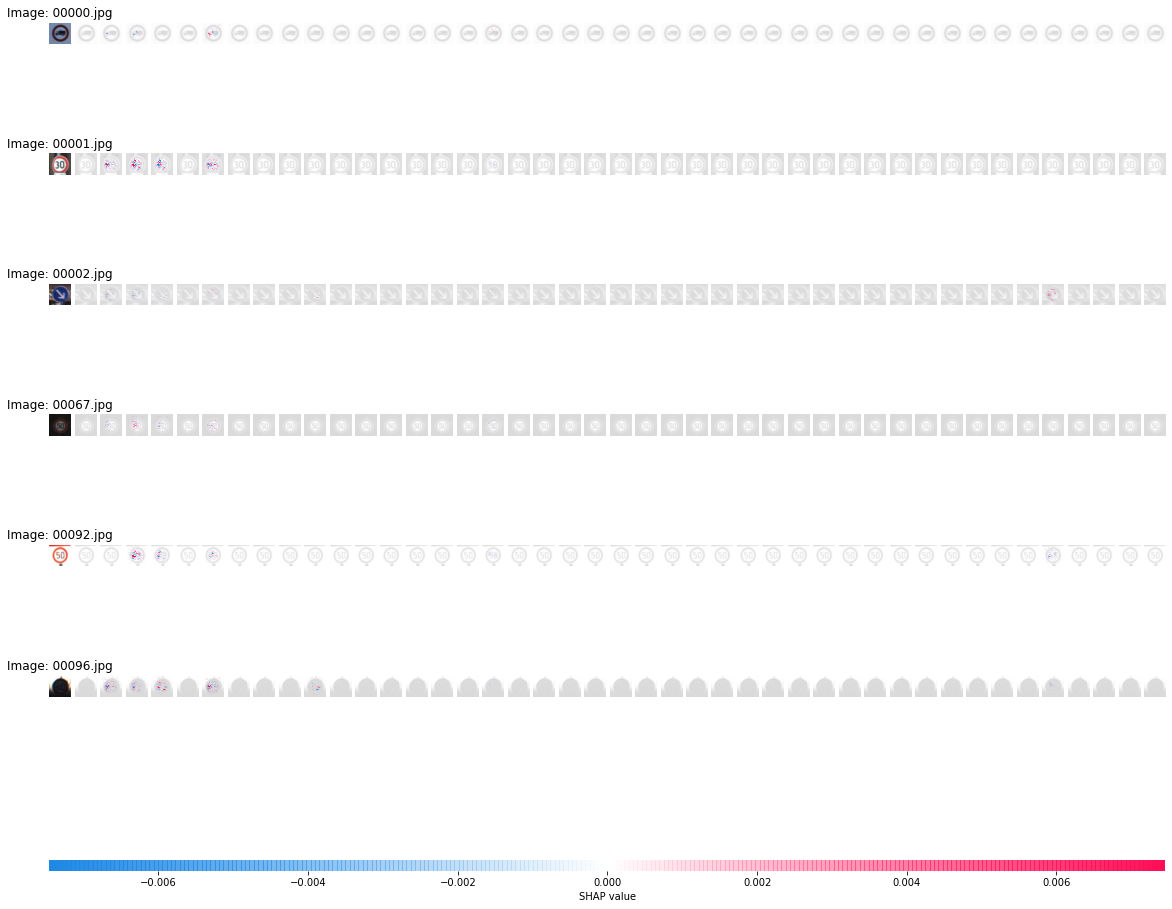

In [ ]:
image_plot(shap_values_positive, background, labels=lbls, preds=eval_df['preds'].values, 
           names=eval_df['image_name'].values, fig_size=(20, 20))

In [ ]:
shap.initjs()
shap.force_plot(
    shap_values_positive.expected_value[0], shap_values[0][0]
)

AttributeError: ignored

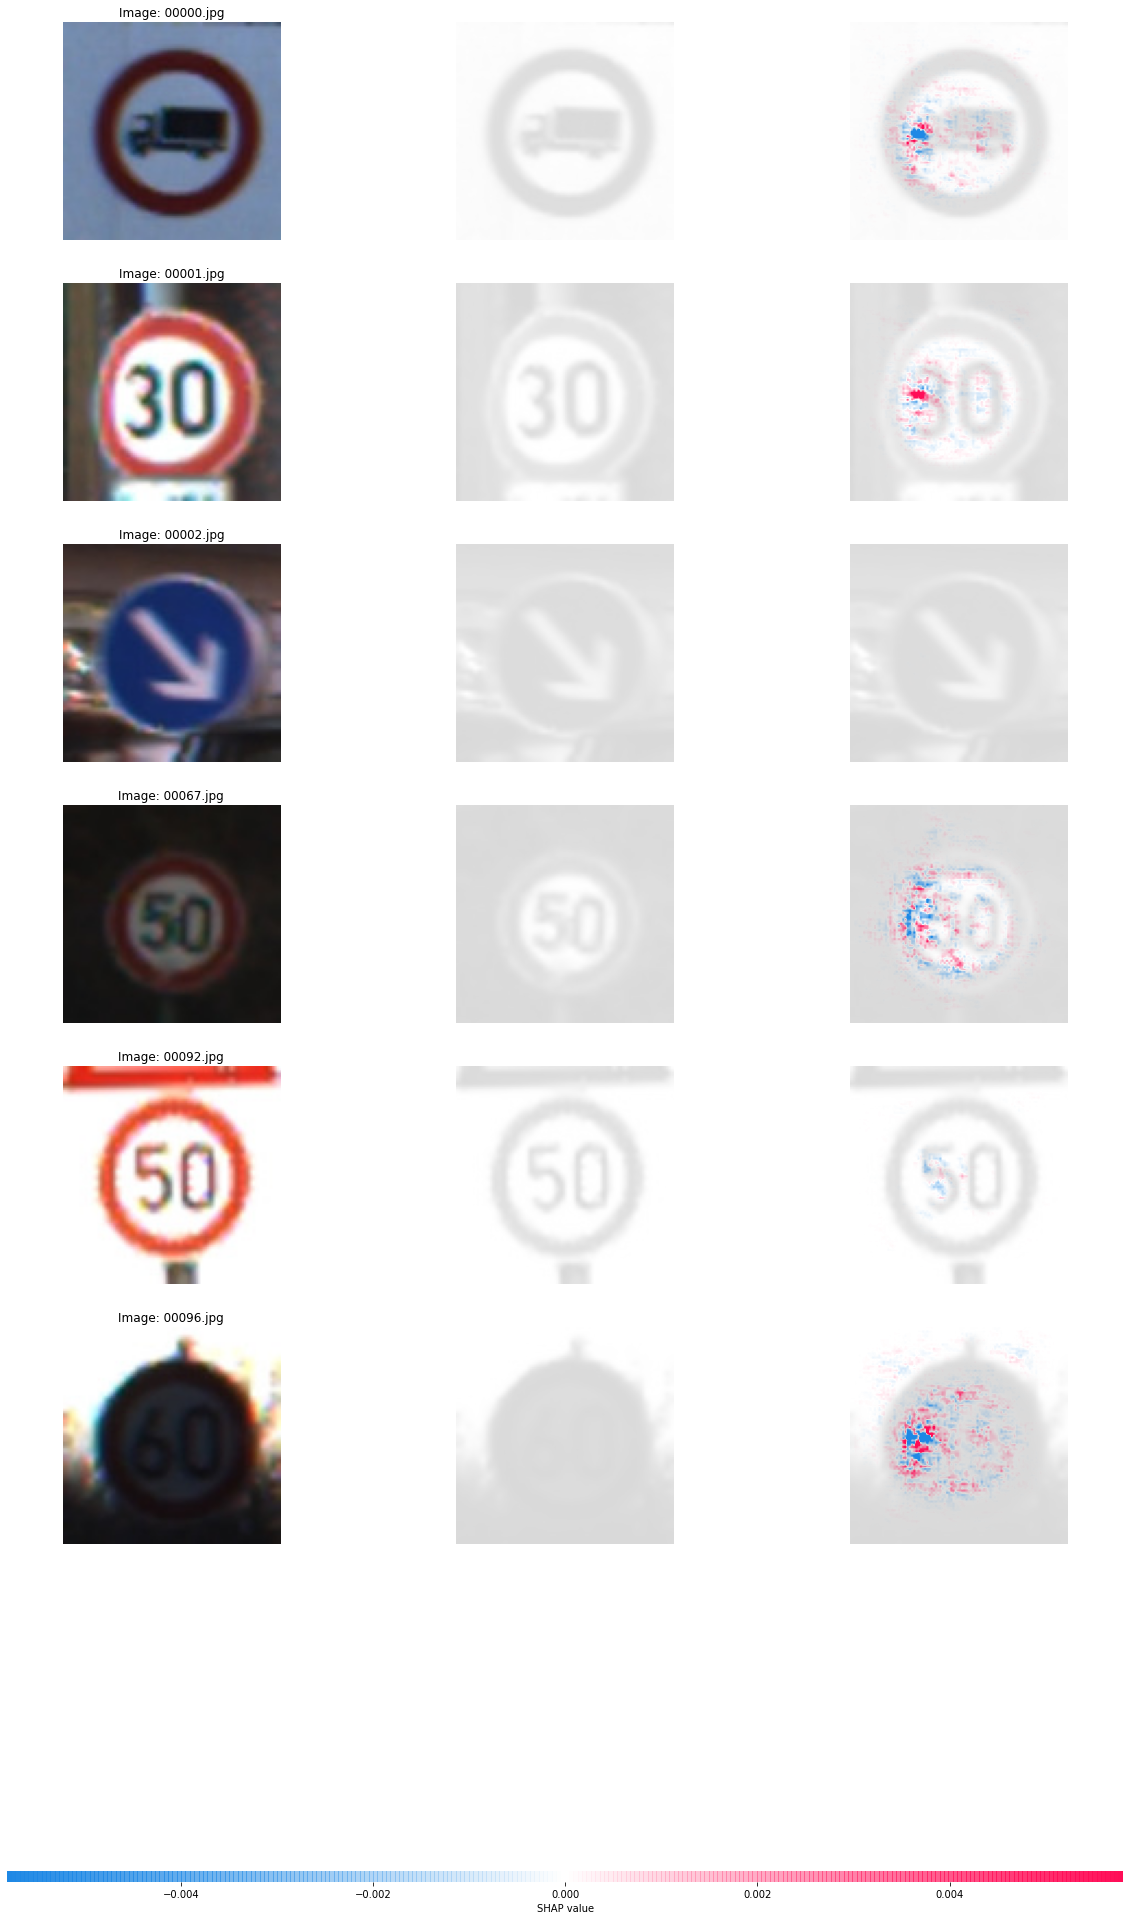

In [ ]:
image_plot(shap_values, background, labels=lbls, preds=eval_df['preds'], names=eval_df['image_name'],hspace=0.2) 

In [ ]:
# shap_plot = shap.image_plot(shap_values, -x_test[1:6])
# display(shap_plot)